# 第一部分 - 导入所需要的数据

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2

# Config
sqluser = 'postgres'
dbname = 'mimic'
schema_name = 'mimiciii'

# Connect to MIMIC
con = psycopg2.connect(dbname=dbname, user=sqluser, password = '3326999')
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)

query_1 = \
"""
WITH population as (
SELECT a.subject_id, a.hadm_id, i.icustay_id, 
    a.admittime as hosp_admittime, a.dischtime as hosp_dischtime, 
    i.first_careunit, 
    DENSE_RANK() over(PARTITION BY a.hadm_id ORDER BY i.intime ASC) as icu_seq,
    p.dob, p.dod, i.intime as icu_intime, i.outtime as icu_outtime, 
    i.los as icu_los,
    round((EXTRACT(EPOCH FROM (a.dischtime-a.admittime))/60/60/24) :: NUMERIC, 4) as hosp_los, 
    p.gender, 
    round((EXTRACT(EPOCH FROM (a.admittime-p.dob))/60/60/24/365.242) :: NUMERIC, 4) as age_hosp_in,
    round((EXTRACT(EPOCH FROM (i.intime-p.dob))/60/60/24/365.242) :: NUMERIC, 4) as age_icu_in,
    hospital_expire_flag,
    CASE WHEN p.dod IS NOT NULL 
        AND p.dod >= i.intime - interval '6 hour'
        AND p.dod <= i.outtime + interval '6 hour' THEN 1 
        ELSE 0 END AS icu_expire_flag
FROM admissions a
INNER JOIN icustays i
ON a.hadm_id = i.hadm_id
INNER JOIN patients p
ON a.subject_id = p.subject_id
ORDER BY a.subject_id, i.intime
)
SELECT *
FROM population
WHERE age_hosp_in >= 16;
"""
query_output_1 = pd.read_sql_query(query_1,con)

query_2 = \
"""
WITH diagnoses_icu AS (
SELECT a.subject_id, a.hadm_id, i.icustay_id, 
    a.admittime as hosp_admittime, a.dischtime as hosp_dischtime, 
    i.first_careunit, 
    DENSE_RANK() over(PARTITION BY a.hadm_id ORDER BY i.intime ASC) as icu_seq,
    p.dob, p.dod, i.intime as icu_intime, i.outtime as icu_outtime, 
    i.los as icu_los,
    round((EXTRACT(EPOCH FROM (a.dischtime-a.admittime))/60/60/24) :: NUMERIC, 4) as hosp_los, 
    p.gender, 
    round((EXTRACT(EPOCH FROM (a.admittime-p.dob))/60/60/24/365.242) :: NUMERIC, 4) as age_hosp_in,
    round((EXTRACT(EPOCH FROM (i.intime-p.dob))/60/60/24/365.242) :: NUMERIC, 4) as age_icu_in,
    hospital_expire_flag,
    CASE WHEN p.dod IS NOT NULL 
        AND p.dod >= i.intime - interval '6 hour'
        AND p.dod <= i.outtime + interval '6 hour' THEN 1 
        ELSE 0 END AS icu_expire_flag
    FROM admissions a
    INNER JOIN icustays i
    ON a.hadm_id = i.hadm_id
    INNER JOIN patients p
    ON a.subject_id = p.subject_id
    ORDER BY a.subject_id, i.intime)
SELECT d.subject_id, d.hadm_id, d.icustay_id, d.first_careunit,
    icd.seq_num, icd.icd9_code, left(icd.icd9_code,3) AS icd_first3, 
    CASE
        WHEN lower(LEFT(icd.icd9_code,1)) = 'e' THEN NULL
        WHEN lower(LEFT(icd.icd9_code,1)) = 'v' THEN NULL
        ELSE CAST( LEFT(icd.icd9_code,3) AS INT) END AS icd_first3_num,
    CASE 
        WHEN lower(LEFT(icd.icd9_code,1)) = 'e' THEN 9
        WHEN lower(LEFT(icd.icd9_code,1)) = 'v' THEN 9
        WHEN CAST( LEFT(icd.icd9_code,3) AS INT) >=0 
            AND CAST( LEFT(icd.icd9_code,3) AS INT) <= 139 THEN 0
        WHEN CAST( LEFT(icd.icd9_code,3) AS INT) >=140 
            AND CAST( LEFT(icd.icd9_code,3) AS INT) <= 239 THEN 1
        WHEN CAST( LEFT(icd.icd9_code,3) AS INT) >=240 
            AND CAST( LEFT(icd.icd9_code,3) AS INT) <= 279 THEN 2
        WHEN CAST( LEFT(icd.icd9_code,3) AS INT) >=390 
            AND CAST( LEFT(icd.icd9_code,3) AS INT) <= 459 THEN 3
        WHEN CAST( LEFT(icd.icd9_code,3) AS INT) >=460 
            AND CAST( LEFT(icd.icd9_code,3) AS INT) <= 519 THEN 4
        WHEN CAST( LEFT(icd.icd9_code,3) AS INT) >=520 
            AND CAST( LEFT(icd.icd9_code,3) AS INT) <= 579 THEN 5
        WHEN CAST( LEFT(icd.icd9_code,3) AS INT) >=580 
            AND CAST( LEFT(icd.icd9_code,3) AS INT) <= 629 THEN 6
        WHEN CAST( LEFT(icd.icd9_code,3) AS INT) >=800 
            AND CAST( LEFT(icd.icd9_code,3) AS INT) <= 959 THEN 7
        WHEN CAST( LEFT(icd.icd9_code,3) AS INT) >=960 
            AND CAST( LEFT(icd.icd9_code,3) AS INT) <= 989 THEN 8
        ELSE 9 END AS icd_first3_grp, 
    d_icd.short_title
FROM diagnoses_icu d
INNER JOIN diagnoses_icd icd
    ON d.hadm_id = icd.hadm_id
INNER JOIN d_icd_diagnoses d_icd
    ON icd.icd9_code = d_icd.icd9_code
WHERE seq_num =1
    AND age_hosp_in >=16;
"""

query_output_2 = pd.read_sql_query(query_2,con)

a=query_output_2.drop_duplicates(['hadm_id']).loc[query_output_2.first_careunit=='CCU']['icd_first3_grp'].value_counts()
b=query_output_2.drop_duplicates(['hadm_id']).loc[query_output_2.first_careunit=='CSRU']['icd_first3_grp'].value_counts()
c=query_output_2.drop_duplicates(['hadm_id']).loc[query_output_2.first_careunit=='MICU']['icd_first3_grp'].value_counts()
d=query_output_2.drop_duplicates(['hadm_id']).loc[query_output_2.first_careunit=='SICU']['icd_first3_grp'].value_counts()
e=query_output_2.drop_duplicates(['hadm_id']).loc[query_output_2.first_careunit=='TSICU']['icd_first3_grp'].value_counts()
f=query_output_2.drop_duplicates(['hadm_id'])['icd_first3_grp'].value_counts()
df_num=pd.concat([a,b,c,d,e,f],axis=1)
df_num.fillna(value=0, inplace=True)
df_num.columns = ['CCU', 'CSRU','MICU','SICU','TSICU','Total']


a=(a/query_output_2.drop_duplicates(['hadm_id']).loc[query_output_2.first_careunit=='CCU']['icd_first3_grp'].count())*100
b=(b/query_output_2.drop_duplicates(['hadm_id']).loc[query_output_2.first_careunit=='CSRU']['icd_first3_grp'].count())*100
c=(c/query_output_2.drop_duplicates(['hadm_id']).loc[query_output_2.first_careunit=='MICU']['icd_first3_grp'].count())*100
d=(d/query_output_2.drop_duplicates(['hadm_id']).loc[query_output_2.first_careunit=='SICU']['icd_first3_grp'].count())*100
e=(e/query_output_2.drop_duplicates(['hadm_id']).loc[query_output_2.first_careunit=='TSICU']['icd_first3_grp'].count())*100
f=(f/query_output_2.drop_duplicates(['hadm_id'])['icd_first3_grp'].count())*100
df_percent=pd.concat([a,b,c,d,e,f],axis=1)
df_percent.fillna(value=0, inplace=True)
df_percent.columns = ['CCU', 'CSRU','MICU','SICU','TSICU','Total']

# 第二部分 - 数据探索和可视化

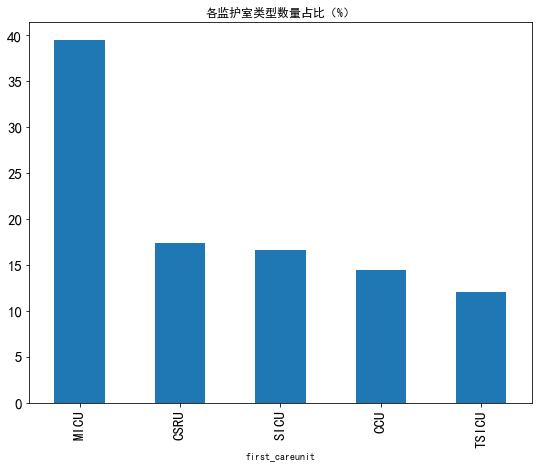

In [50]:
q = query_output_1[['first_careunit','icustay_id']] \
                    .drop_duplicates(['icustay_id']) \
                    .groupby('first_careunit') \
                    .count()/len(query_output_1.icustay_id.unique())*100
q.sort_values(by = ['icustay_id'], inplace = True, ascending=False)
q.plot(kind='bar', title = "各监护室类型数量占比（%）", legend=False,figsize=(9,7), fontsize = 15);

Text(0.5, 0.98, '年龄在各监护室的分布情况')

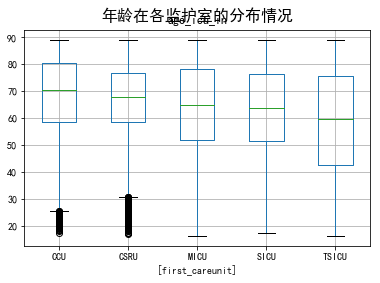

In [49]:
q = query_output_1[['icustay_id','first_careunit','age_icu_in']] \
                    .drop_duplicates(['icustay_id']) 
                  
q.loc[q['age_icu_in'] > 300, 'age_icu_in'] = 89

axes = q[['first_careunit', 'age_icu_in']].boxplot(by='first_careunit')
fig = axes.get_figure()
fig.suptitle('年龄在各监护室的分布情况', fontsize=16, fontweight='bold')

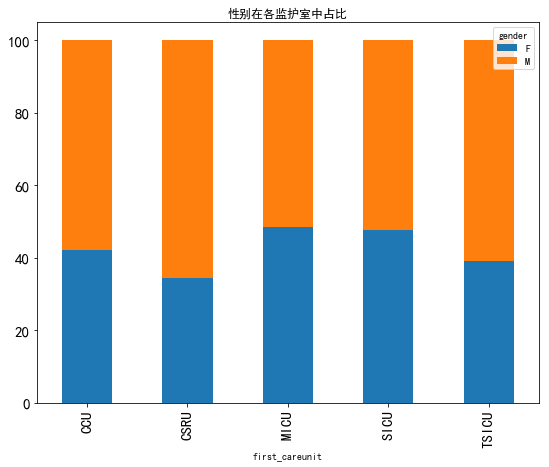

In [43]:
q = query_output_1.loc[query_output_1.icu_seq==1] \
    .groupby(['first_careunit','gender']) \
    .gender.count()/query_output_1.loc[query_output_1.icu_seq==1] \
    .groupby(['first_careunit']).gender.count()*100    
q.unstack().plot(kind = 'bar', stacked = True, title = '性别在各监护室中占比',figsize=(9,7), fontsize = 15)

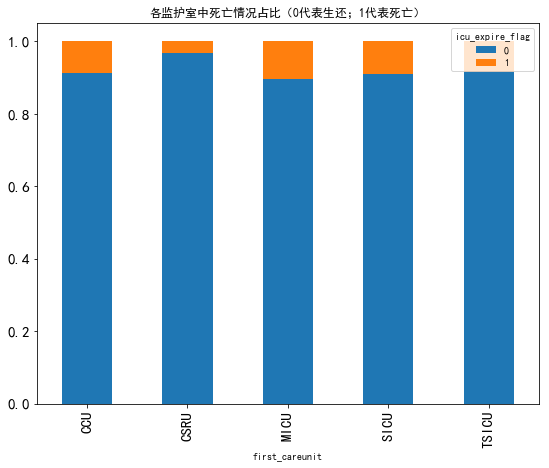

In [40]:
q = query_output_1 \
    .groupby(['first_careunit','icu_expire_flag']) \
    .icu_expire_flag.count()/query_output_1 \
    .groupby(['first_careunit']).icu_expire_flag.count()
q.unstack().plot(kind = 'bar', stacked = True, title = '各监护室中死亡情况占比（0代表生还；1代表死亡）',figsize=(9,7), fontsize = 15)

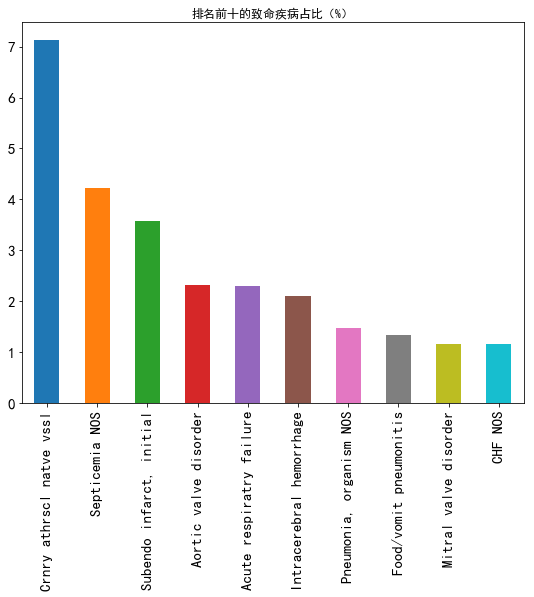

In [56]:
q = query_output_2.drop_duplicates(['hadm_id'])['short_title'].value_counts().head(n=10) \
     /len(query_output_2.drop_duplicates(['hadm_id'])['short_title'])*100
     
q.plot(kind='bar', title = '排名前十的致命疾病占比（%）',figsize=(9,7), fontsize = 15)   

0：Infectious and parasitic diseases（感染和寄生疾病）  
1：Neoplasms of digestive organs and intrathoracic organs, etc（胸内和消化系统肿瘤）  
2：Endocrine, nutritional, metabolic, and immunity（内分泌、代谢、和免疫系统）  
3：Diseases of the circulatory system（循环系统疾病）  
4：Pulmonary diseases（肺部疾病）  
5：Diseases of the digestive system（消化系统疾病）  
6：Diseases of the genitourinary system（泌尿系统疾病）  
7：Trauma（创伤）  
8：Poisoning by drugs and biological substances（中毒）  
9：Other（其他）  

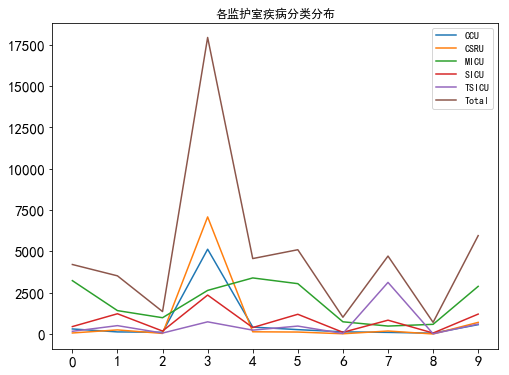

In [60]:
df_num.plot(title='各监护室疾病分类分布', xticks=[0,1,2,3,4,5,6,7,8,9],figsize=(8,6), fontsize = 15)

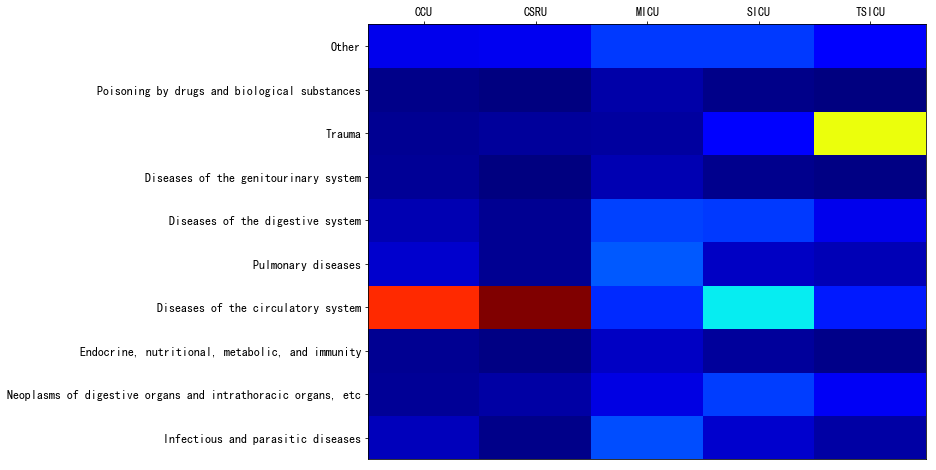

In [36]:
data = df_percent[['CCU', 'CSRU','MICU','SICU','TSICU']].values
row_labels = list(['CCU', 'CSRU','MICU','SICU','TSICU'])
column_labels = list(
    ['Infectious and parasitic diseases',
     'Neoplasms of digestive organs and intrathoracic organs, etc',
     'Endocrine, nutritional, metabolic, and immunity',
     'Diseases of the circulatory system',
     'Pulmonary diseases',
     'Diseases of the digestive system',
     'Diseases of the genitourinary system',
     'Trauma',
     'Poisoning by drugs and biological substances',
     'Other'])
fig, ax = plt.subplots(figsize=(10,8))
heatmap = ax.pcolor(data, cmap=plt.cm.jet)

# move labels to top
ax.xaxis.tick_top()

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(data.shape[1])+0.5, minor=False)
ax.set_yticks(np.arange(data.shape[0])+0.5, minor=False)

ax.set_xticklabels(row_labels, minor=False,fontsize=12)
ax.set_yticklabels(column_labels, minor=False,fontsize=12)

plt.show()